In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [3]:
head = "/home/dhoogla/PhD/clean-ids-collection"
cidds_data = {
    "cidds-001-external-1": f"{head}/cidds-001/dirty-with-metadata/traffic/ExternalServer/CIDDS-001-external-week1.parquet", # only benign
    "cidds-001-external-2": f"{head}/cidds-001/dirty-with-metadata/traffic/ExternalServer/CIDDS-001-external-week2.parquet",
    "cidds-001-external-3": f"{head}/cidds-001/dirty-with-metadata/traffic/ExternalServer/CIDDS-001-external-week3.parquet",
    "cidds-001-external-4": f"{head}/cidds-001/dirty-with-metadata/traffic/ExternalServer/CIDDS-001-external-week4.parquet",
    "cidds-001-internal-1": f"{head}/cidds-001/dirty-with-metadata/traffic/OpenStack/CIDDS-001-internal-week1.parquet",
    "cidds-001-internal-2": f"{head}/cidds-001/dirty-with-metadata/traffic/OpenStack/CIDDS-001-internal-week2.parquet",
    "cidds-001-internal-3": f"{head}/cidds-001/dirty-with-metadata/traffic/OpenStack/CIDDS-001-internal-week3.parquet",
    "cidds-001-internal-4": f"{head}/cidds-001/dirty-with-metadata/traffic/OpenStack/CIDDS-001-internal-week4.parquet",
    "cidds-002-internal-1": f"{head}/cidds-002/dirty-with-metadata/traffic/week1.parquet",
    "cidds-002-internal-2": f"{head}/cidds-002/dirty-with-metadata/traffic/week2.parquet",
}

In [4]:
dataset = "cidds-001-external-2"
datapaths = [f"{cidds_data[dataset]}"]

In [5]:
df = pd.concat(objs=[pd.read_parquet(path) for path in datapaths], ignore_index=True, copy=False, sort=False, verify_integrity=False)

In [6]:
df.columns

Index(['date_first_seen', 'duration', 'proto_GRE', 'proto_ICMP', 'proto_TCP',
       'proto_UDP', 'src_ip_addr', 'src_pt', 'dst_ip_addr', 'dst_pt',
       'packets', 'bytes', 'flows', 'tcp_urg', 'tcp_ack', 'tcp_psh', 'tcp_rst',
       'tcp_syn', 'tcp_fin', 'tos', 'class', 'attack_type', 'attack_id',
       'attack_description'],
      dtype='object')

In [7]:
df = df[['dst_pt', 'attack_type']]
df['attack_type'] = df['attack_type'].astype(dtype='object')
df['attack_type'].value_counts()

benign        154228
portScan        4010
bruteForce       768
Name: attack_type, dtype: int64

In [8]:
label_idx = df.columns.size -1
attacks = df.loc[df['attack_type'] != "benign"].index
df.iloc[attacks, label_idx] = 1.0
df.iloc[df.index.difference(attacks), label_idx] = 0.0
df['attack_type'] = df['attack_type'].astype(dtype='float32', copy=False)


In [9]:
col = df.columns[-1]
cols = df.columns[:-1]
vc = df[col].value_counts()
n = vc.iloc[-1]
m = vc.iloc[0]
initial_cut = df.loc[df[col] == vc.index[0]].sample(n=int(m-n), replace=False)
df = df.drop(index=initial_cut.index)

In [10]:
df.shape
df['attack_type'].value_counts()

0.0    4778
1.0    4778
Name: attack_type, dtype: int64

In [11]:
gp = df.groupby('attack_type')
with pd.option_context('display.max_rows', 50):
    print(gp.get_group(0.0)['dst_pt'].value_counts())
    print(gp.get_group(1.0)['dst_pt'].value_counts())

22.0       1392
8000.0      461
80.0        164
23.0        127
3.3          43
           ... 
15334.0       1
37573.0       1
47041.0       1
58738.0       1
57260.0       1
Name: dst_pt, Length: 2362, dtype: int64
62917.0    1000
44712.0    1000
22.0        386
80.0          3
443.0         3
           ... 
50848.0       1
50846.0       1
50844.0       1
50842.0       1
51378.0       1
Name: dst_pt, Length: 1388, dtype: int64


TypeError: vars() argument must have __dict__ attribute

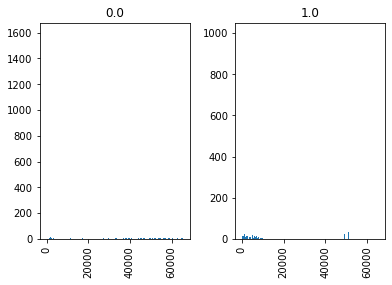

In [12]:
hist = df.hist(column='dst_pt', by='attack_type', bins=1024, log=True)
print(vars(hist))

In [ ]:
model = RF()
best_param_dict = {
        'bootstrap': True,
        'max_depth': 16,
        'max_features': 'sqrt',
        'min_impurity_decrease': 0.0,
        'min_samples_leaf': 2,
        'n_estimators': 10,
        'max_samples': 0.5,
        'criterion': 'entropy',
        'n_jobs': -1,
        }
model.set_params(**best_param_dict)

RandomForestClassifier(criterion='entropy', max_depth=16, max_features='sqrt',
                       max_samples=0.5, min_samples_leaf=2, n_estimators=10,
                       n_jobs=-1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['dst_pt'], df['attack_type'], test_size=0.8, random_state=42)

In [ ]:
model.fit(X=X_train.array.reshape(-1,1), y=y_train.array)

RandomForestClassifier(criterion='entropy', max_depth=16, max_features='sqrt',
                       max_samples=0.5, min_samples_leaf=2, n_estimators=10,
                       n_jobs=-1)

In [ ]:
intra_outputs = model.predict(X=X_test.array.reshape(-1,1))
intra_acc = accuracy_score(y_true=y_test, y_pred=intra_outputs)
intra_rec = recall_score(y_true=y_test, y_pred=intra_outputs)
intra_pre = precision_score(y_true=y_test, y_pred=intra_outputs)
print(f"{dataset} => Destination Port")
print(f"Accuracy: {intra_acc:.3f}")
print(f"Recall: {intra_rec:.3f}")
print(f"Precision: {intra_pre:.3f}")


Destination Port ROC-AUC: 0.874

